# DSCI 100 Group Project Proposal - Group 17

# Predicting fraudulent firms based on audit data

In [1]:
# open packages
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(cowplot)

set.seed(999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction

Auditing firms have a very important responsibility in catching fraud cases. Firms performing audits must carefully examine the financial records of businesses to ensure that they are following accounting laws. To properly perform audits, auditors must go through financial records such as receipts, balance sheets, etc. This is a lot of data to analyze. The question we want to answer is: can fruadulent firms can be correctly predicted using risk factors from the dataset and a k-nearest neighbours approach?

The dataset being used will show annual audit data from 777 firms across 14 different sectors. There are 17 columns of observations in the dataset, the risk class column shows whether the case is fraudulent or not. 

### Variable Information

**Note:** no units were provided for variables

| | Inherent Risk Factors | | Control Risk Factors |
| --- | --- | ---| --- |
| ParaA | Discrepancy in planned-expenditure of inspection and summary report A in Rs | Sector score | Historical risk score value of the target-unit |
| ParaB | Discrepancy in unplanned-expenditure of inspection and summary report B in Rs | Loss | Amount of loss suffered by the firm last year. |
| Total | Total amount of discrepancy found in other reports Rs | History | Average historical loss suffered by firm in the last 10 years. |
| Number | Historical discrepancy score. | District score | Historical risk score of a district in the last 10 years. |
| Money Value | Amount of money involved in misstatements in the past audits. | | |
| Sector ID | Unique ID of the target sector. | Location ID | Unique ID of the city/province. |
| ARS | Total risk score using analytical procedure. | Audit ID | Unique Id assigned to an audit case. |
| Risk class | Risk Class assigned to an audit-case, 1=fraud or 0=no fraud (Target Feature) 

Data source: https://archive.ics.uci.edu/ml/datasets/Audit+Data

Publication: https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

## Preliminary Exploratory Data Analysis

In [2]:
# import the data set, make column names consistent
url <- "https://raw.githubusercontent.com/hakkd/dsci-100-project-group17/main/trial.csv"

column_names = c("sector_score", "location_id", "para_a", "score_a", "para_b", "score_b", 
             "total", "numbers", "marks", "money_value", "money_marks", "district", "loss", 
             "loss_score", "history", "history_score", "score", "risk")

audit_data <- read_csv(url, col_names = column_names, skip = 1)

# dropping location_id column (not useful)
audit_data <- select(audit_data, -location_id)

head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_id
dbl (17): sector_score, para_a, score_a, para_b, score_b, total, numbers, ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


In [3]:
# change Risk to factor and recode as F (fraud) or N (no fraud)
audit_data <- audit_data |>
        mutate(risk = as.factor(risk))

audit_data$risk <- ifelse(audit_data$risk == "1", "F", "N")

# check that output is correct
head(audit_data)

sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.89,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,F
3.89,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,N
3.89,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,F
3.89,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,N
3.89,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,N


In [4]:
# creating training and testing datasets
audit_split <- initial_split(audit_data, prop = 0.75, strata = risk)

audit_train <- training(audit_split)
audit_test <- testing(audit_split)

In [5]:
# check proportion of fraudulent and not fraudulent cases
audit_proportions <- audit_train |>
                      group_by(risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(audit_train))

audit_proportions

risk,n,percent
<chr>,<int>,<dbl>
F,364,62.6506
N,217,37.3494


Based on the table above, this dataset has more fraudulent observations than not-fraudulent ones (~2:1)

In [6]:
# check how many NA values are in each column (if any)
audit_train |>
    map_df(is.na) |>
    map_df(sum)

sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


The data is mostly complete, with only one NA in the money_value column.

In [7]:
# show mean of all columns grouped by risk
audit_train |> 
    group_by(risk) |>
    summarize(across(sector_score:score , mean, na.rm = TRUE))

risk,sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,14.31055,3.6789852,4.335165,17.7437912,3.741758,21.3551940,5.10989,2.368132,23.3347527,3.428571,2.846154,0.05494505,2.115385,0.1428571,2.252747,3.093956
N,31.53065,0.3056221,2.000000,0.2499889,2.000000,0.5556111,5.00000,2.000000,0.2232593,2.000000,2.000000,0.00000000,2.000000,0.0000000,2.000000,2.000000


Based on the output above showing column mean grouped by fraud and no fraud cases, there are differences in the means of some of the variables. The greatest differences are in para_a, para_b and total (expenditure discrepancy) and money_value. These variables may be good candidates for predictors in our classifier.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


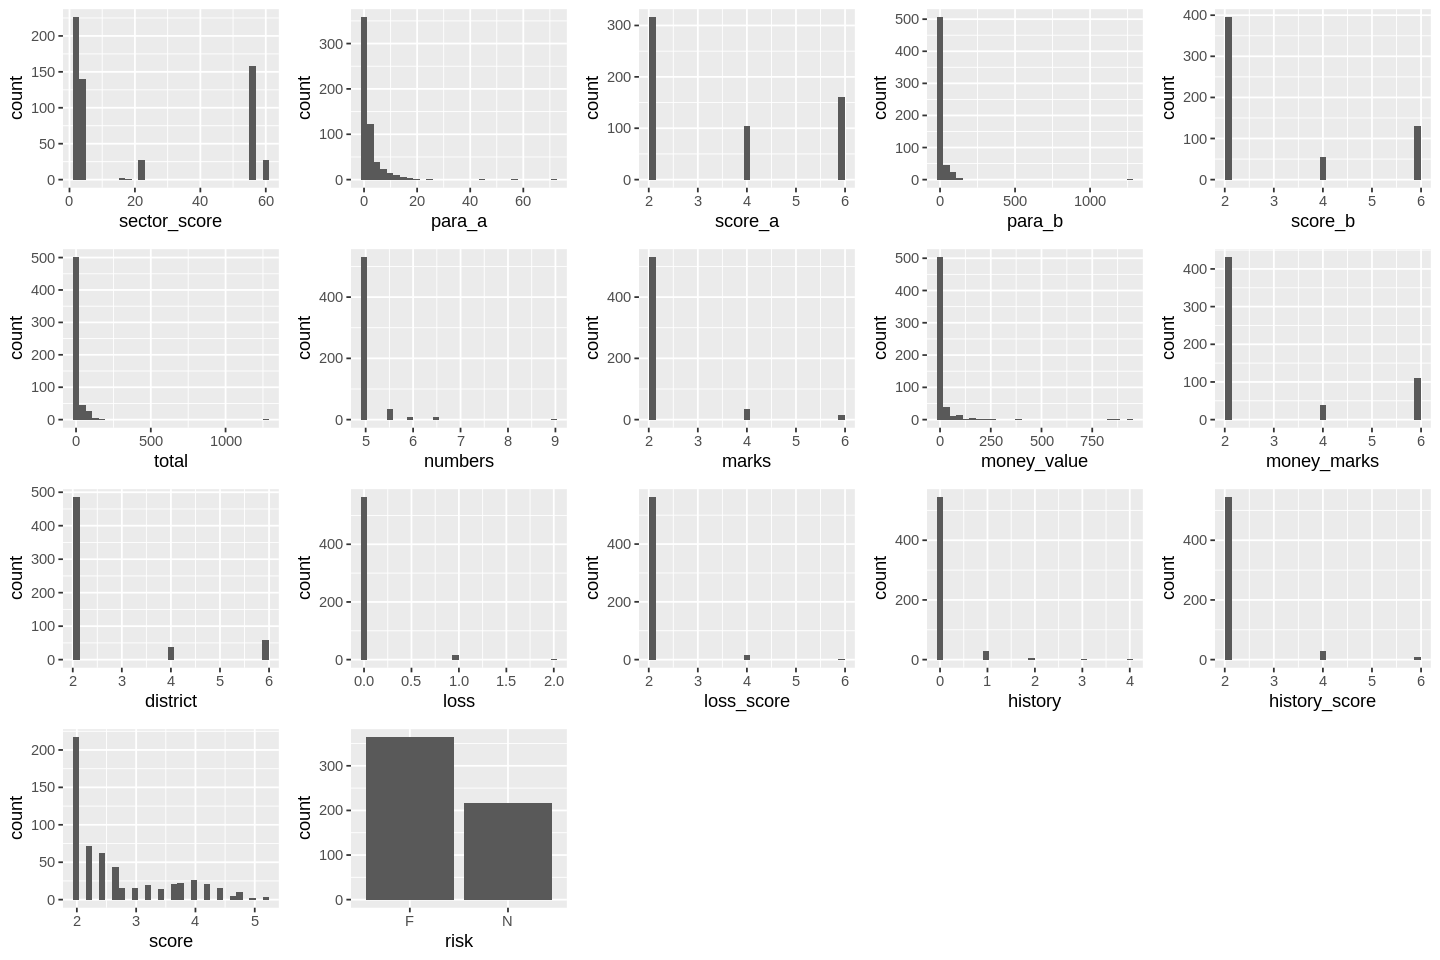

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8)

# show distribution of all variables
# code from:
# https://stackoverflow.com/questions/48507378/plotting-distributions-of-all-columns-in-an-r-data-frame
plots <- lapply(names(audit_train), function(variable_name){
  p <- ggplot(audit_train) +
    aes_string(variable_name)

  if(is.numeric(audit_train[[variable_name]])) {
    p <- p + geom_histogram(bins = 30)

  } else {
    p <- p + geom_bar()
  } 
})

plot_grid(plotlist = plots)

From the distributions of the data above, most of the variables are not continuous. Our classification should focus on the continuous variables para_a, para_b, total and money_value.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


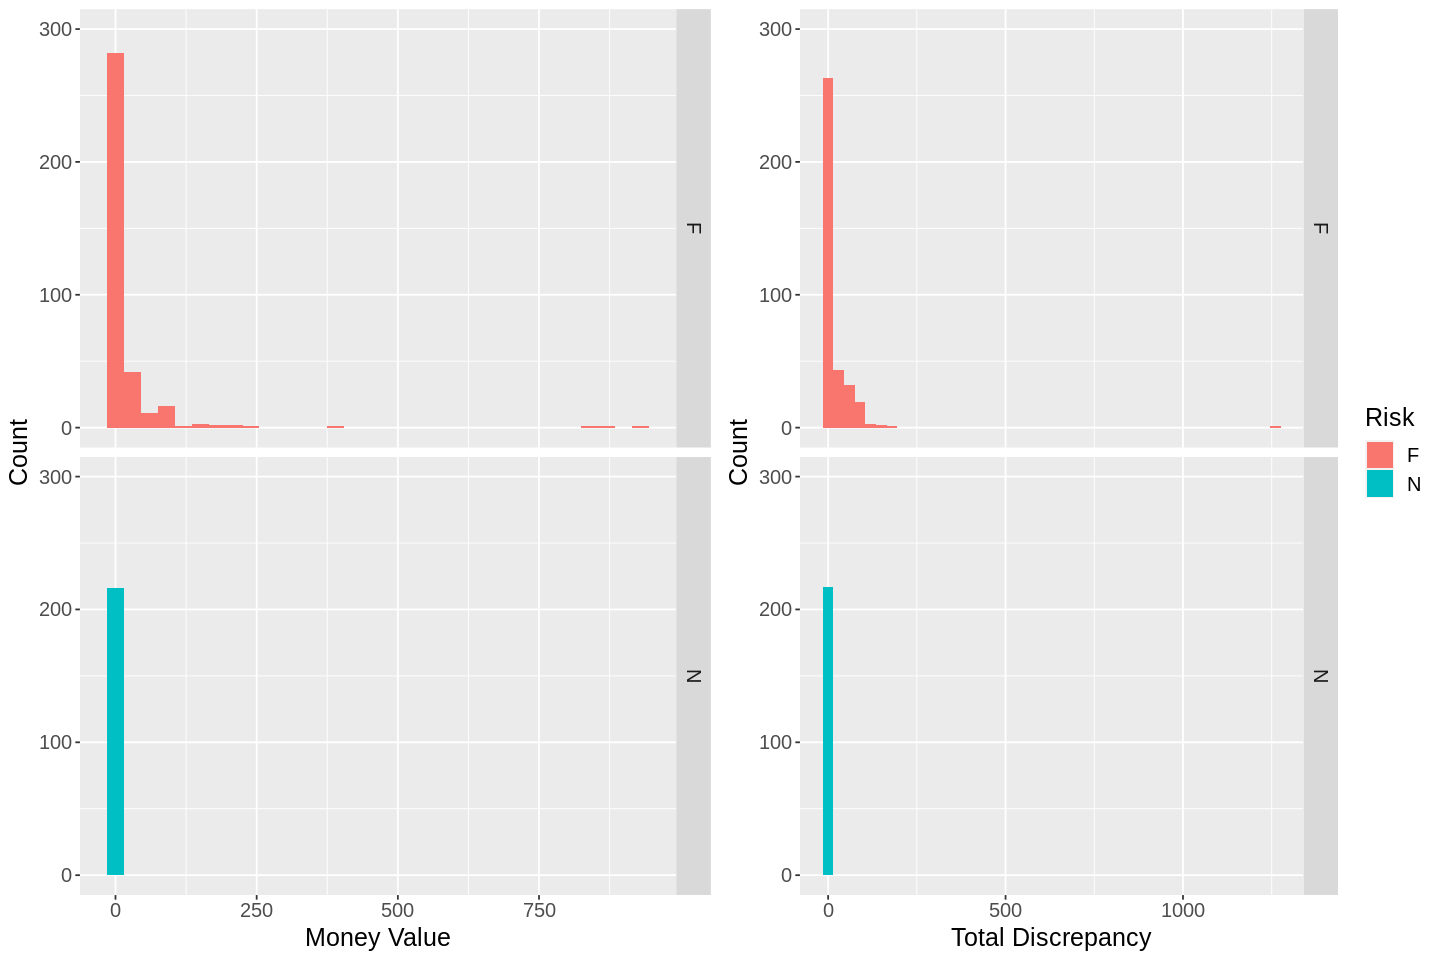

In [9]:
# visualize the distributions of continuous variables
options(repr.plot.width = 12, repr.plot.height = 8)

money_val_plot <- audit_train |>
        ggplot(aes(x = money_value, fill = risk)) + 
        geom_histogram(binwidth = 30, show.legend = FALSE) +
        scale_y_continuous(limits = c(0, 300)) +
        labs(x = "Money Value", y = "Count") +
        facet_grid(risk~.) + 
        theme(text = element_text(size = 15))

total_plot <- audit_train |>
        ggplot(aes(x = total, fill = risk)) + 
        geom_histogram(binwidth = 30) +
        scale_y_continuous(limits = c(0, 300)) +
        labs(x = "Total Discrepancy", y = "Count", fill = "Risk") +
        facet_grid(risk~.) + 
        theme(text = element_text(size = 15))

grid.arrange(money_val_plot, total_plot, nrow = 1)

We can see that the distributions of these data are skewed, but higher values of the money_value and total (discrepancy based on para_a and para_b) are associated with fraudulent cases. 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


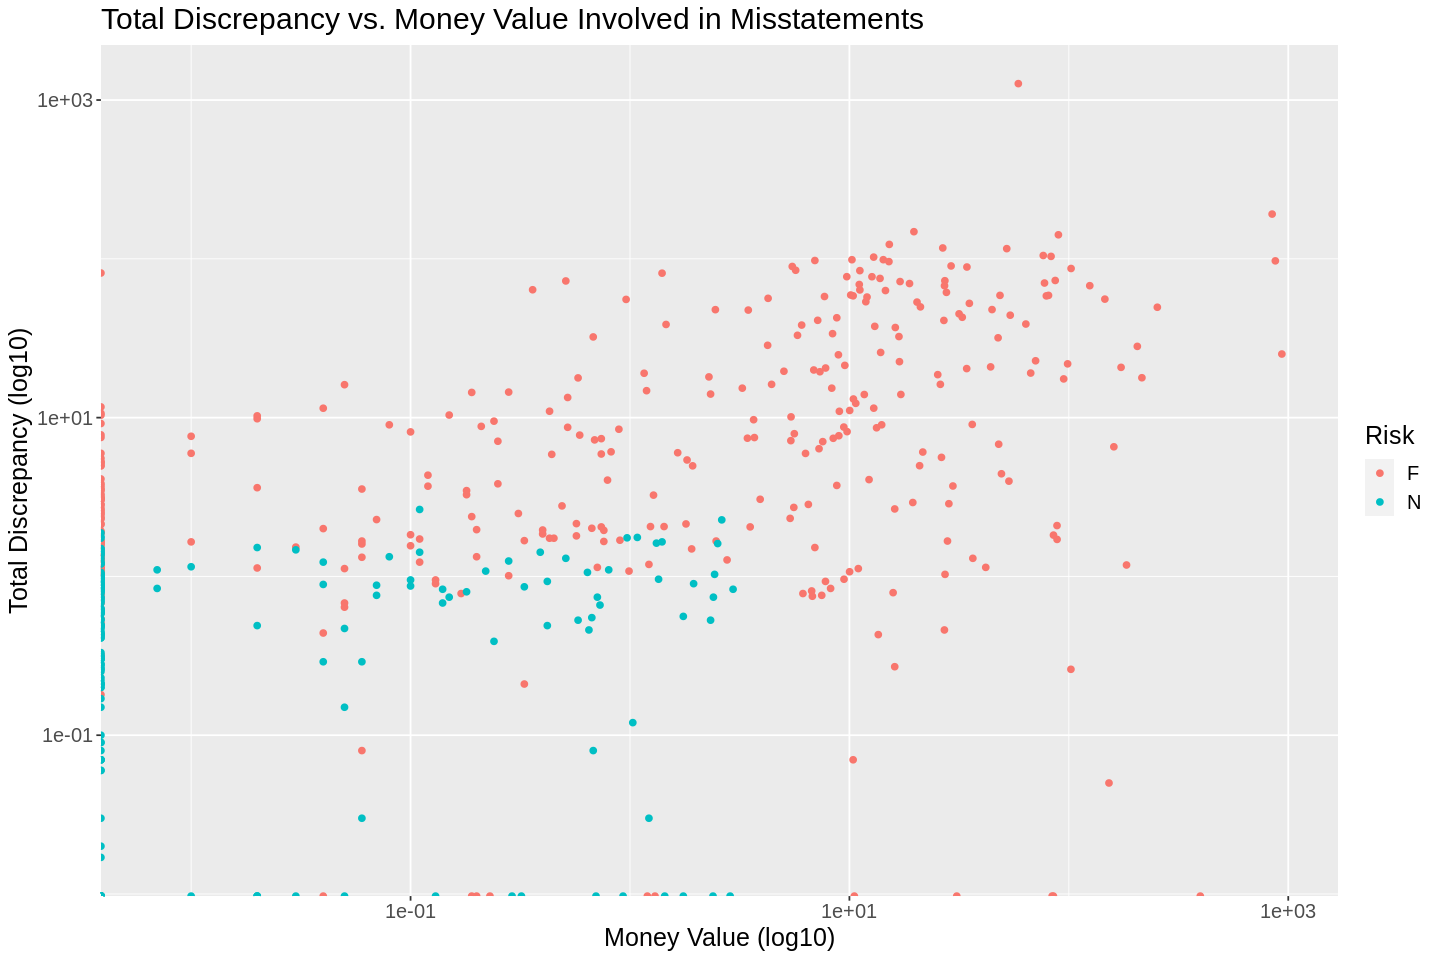

In [10]:
# make a scatter plot to compare the two variables of interest
audit_scatter <- audit_train |>
        ggplot(aes(x = money_value, y = total, colour = risk, fill = risk)) +
        geom_point() +
        scale_x_continuous(trans = "log10")+
        scale_y_continuous(trans = "log10") +
        labs(fill = "Risk", 
             colour = "Risk", 
             x = "Money Value (log10)", 
             y = "Total Discrepancy (log10)") +
        ggtitle("Total Discrepancy vs. Money Value Involved in Misstatements") +
        theme(text = element_text(size = 15))

audit_scatter

This scatterplot shows that higher values of total discrepancy and money value seem to correlate with fraudulent cases.

## Methods

We plan to use the K-nearest neighbours classification algorithm to predict if a particular firm is likely to be involved in fraudulent activity. First, we will split the data into a training set and a testing set. We will tune our model to use the most relevant variables for our predictors and use cross-validation to find the best K to use for our model. Our preliminary data analysis above suggests that the continuous variables total, para_a, para_b and money_value can be used. Another way we will improve the model is by testing different weight functions. It may end up that Euclidian distance (weight_func = "rectangular") is the best for our model, but we will not rule out other weight functions at this stage.

One way to visualize our results would be using a variety of line graphs showing the estimated accuracy of the model for different combinations of predictors. Each individual graph would be for a specific combination of predictors, and within each graph, we would plot the estimated accuracy against the K value. This visualization will display which predictors and K value have the best estimated accuracy, which could be useful for choosing which firms to audit in the future.

## Expected Outcomes and Significance

According to the plotted values and data, we can make an argument that in both para_A and para_B, as money_value increased
total discrepancy increased too. As a result, we expect to find the same correlation between other cases, meaning that as
the money_value variable increases amongst different sectors, the chances fraud increase with it.
These findings will show how the amount of money involved in misstatements by a firm impacts the integrity
of the work that they are doing. We can use this data to monitor bigger firms more closely in the future and reduce the amount 
of discrepancy and fraud. Looking at these datasets and charts, a big question comes to mind. Are there organizing bodies and 
authorities who are in charge of monitoring the precision and integrity of the numbers that these firms are publishing? If so, 
why aren't they doing anything about the discrepancy of these numbers?